## 数据预处理

In [1]:
import os
import numpy as np
import torch
import json


# 设置随机数生成器种子
seed = 24
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


def read_classes(classes_file_path):
    """
    从classes.txt文件中读取类别列表
    Args:
        classes_file_path (str): classes.txt文件路径

    Returns:
        list: 类别列表
    """
    with open(classes_file_path, 'r') as file:
        classes = file.readline().strip().split()
    return classes


def read_labels(label_file_path, num_classes):
    """
    从label文件中读取独热码标签
    Args:
        label_file_path (str): 标签文件路径
        num_classes (int): 类别数量

    Returns:
        np.array: 独热码标签
    """
    with open(label_file_path, 'r') as file:
        line = file.readline().strip()
        labels = [int(x) for x in line.split()]
    return np.array(labels)


def load_dataset(dataset_folder):
    """
    加载多标签分类数据集
    Args:
        dataset_folder (str): 数据集文件夹路径

    Returns:
        list, list: 图像路径列表，标签列表
    """
    images_folder = os.path.join(dataset_folder, 'images')
    labels_folder = os.path.join(dataset_folder, 'labels')
    classes_file_path = os.path.join(dataset_folder, 'classes.txt')

    classes = read_classes(classes_file_path)

    image_paths = []
    labels = []

    for label_file in os.listdir(labels_folder):
        if label_file.endswith('.txt'):
            image_file = label_file.replace('.txt', '.jpg')
            image_path = os.path.join(images_folder, image_file)
            label_file_path = os.path.join(labels_folder, label_file)
            label = read_labels(label_file_path, len(classes))
            image_paths.append(image_path)
            labels.append(label)

    return image_paths, labels, classes


# print(os.getcwd())
dataset_folder = "./data/dataset_new/coating_state"
image_paths, labels, classes = load_dataset(dataset_folder)
print("Number of images:", len(image_paths))
print("Number of labels:", len(labels))
print("Number of classes:", len(classes))

os.makedirs(
    "./tongue-disease-classification/coating_state/best_model", exist_ok=True)
with open("./tongue-disease-classification/coating_state/best_model/classes.json", 'w') as file:
    json.dump(classes, file)

Number of images: 91
Number of labels: 91
Number of classes: 3


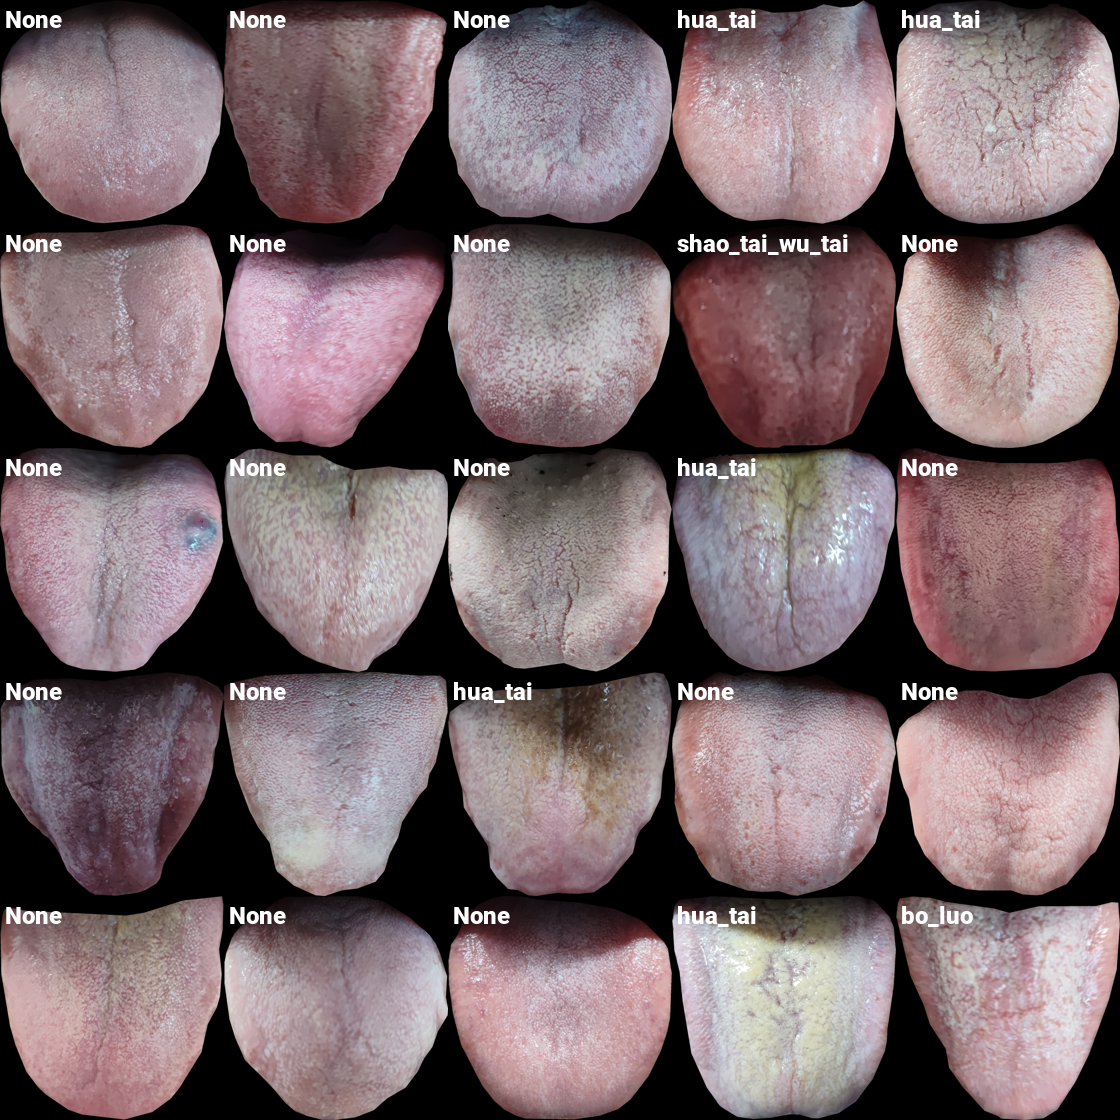

In [2]:
from PIL import Image, ImageDraw, ImageFont


def show_multi_label_examples(image_paths, labels, classes, n: int, m: int, size=(224, 224)):
    w, h = size
    num_classes = len(classes)

    # 计算每行显示的示例数量
    examples_per_row = m
    # 计算显示示例的行数
    num_rows = n
    # 计算网格图像的大小
    grid_size = (examples_per_row * w, num_rows * h)

    grid = Image.new('RGB', size=grid_size, color=(255, 255, 255))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("C:\\Users\\ChenXi\\fonts\\Roboto\\Roboto-Black.ttf", 24)

    for row in range(num_rows):
        for col in range(examples_per_row):
            idx = row * examples_per_row + col

            # 获取图片路径和对应的标签
            img_path = image_paths[idx]
            img_label = labels[idx]

            # 读取图片
            image = Image.open(img_path)

            # 读取图像的 Exif 信息，获取方向信息
            exif = image._getexif()
            orientation = exif.get(0x0112, 1) if exif else 1

            # 根据方向信息旋转图像
            if orientation == 1:
                pass
            elif orientation == 3:
                image = image.rotate(180, expand=True)
            elif orientation == 6:
                image = image.rotate(270, expand=True)
            elif orientation == 8:
                image = image.rotate(90, expand=True)

            image = image.resize(size)

            # 绘制图片
            box = (col * w, row * h)
            grid.paste(image, box=box)

            # 读取图片的标签
            label_indices = img_label
            labels_text = [classes[i] for i in range(num_classes) if label_indices[i] == 1]
            label_text = '\n'.join(labels_text) if labels_text else 'None'

            # 在图片左上角写标签
            draw.text((box[0] + 5, box[1] + 5), label_text, (255, 255, 255), font=font)

    return grid


show_multi_label_examples(image_paths, labels, classes, n=5, m=5)

In [3]:
from torch.utils.data import DataLoader
from torchvision import transforms


class MultiLabelDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


# 数据预处理和转换
dataset_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 创建数据集
dataset = MultiLabelDataset(image_paths, labels)

# 创建数据加载器
batch_size = len(dataset)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
dataloader.dataset.transform = dataset_transform
# 获取所有图像数据
all_images = None

for inputs, _ in dataloader:
    all_images = inputs

# 计算数据集的均值和标准差
mean = torch.mean(all_images, dim=(0, 2, 3))
std = torch.std(all_images, dim=(0, 2, 3))

print(f"均值：{mean}")
print(f"标准差：{std}")

均值：tensor([0.4816, 0.4065, 0.4196])
标准差：tensor([0.2920, 0.2612, 0.2687])


In [4]:
from torch.utils.data import random_split
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import TensorDataset


class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0

        mask = torch.from_numpy(mask)
        img *= mask.unsqueeze(0)

        return img
    

def binary_to_int(binary_label):
    """
    将二进制序列标签转换为一个整数

    Args:
    binary_label (np.ndarray): 二进制序列标签数组

    Returns:
    int: 转换后的整数
    """
    return int(''.join(map(str, binary_label)), 2)

def int_to_binary(number, num_bits):
    """
    将一个整数转换为对应位数的二进制序列标签

    Args:
    number (int): 要转换的整数
    num_bits (int): 二进制序列标签的位数

    Returns:
    np.ndarray: 转换后的二进制序列标签数组
    """
    binary_label = bin(number)[2:].zfill(num_bits)
    return np.array([int(bit) for bit in binary_label])


# 数据增强和预处理
data_augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomApply(transforms.GaussianBlur(3, sigma=(0.1, 2.0)), 0.5),
    Cutout(n_holes=8, length=32),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# 划分数据集
train_size = int(4 / 6.0 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 划分数据集
# train_size = int(4 / 6.0 * len(dataset))
# val_size = int(1 / 6.0 * len(dataset))
# test_size = len(dataset) - train_size - val_size
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# 获取训练集的特征和标签
X_train = []
y_train = []
for inputs, labels in train_dataset:
    X_train.append(inputs.numpy())  # 将张量转换为 numpy 数组
    y_train.append(labels)
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape, y_train.shape, len(X_train))

# 将标签转换为二进制形式
binary_labels = np.array([binary_to_int(label) for label in y_train])
# print(binary_labels)

# 创建 RandomOverSampler 实例
ros = RandomOverSampler(random_state=seed)

# 进行过采样
X_resampled, y_resampled = ros.fit_resample(X_train.reshape(X_train.shape[0], -1), binary_labels)

# 将特征转换回张量形式
X_resampled = torch.tensor(X_resampled.reshape(-1, *inputs.shape))
y_resampled = np.array([int_to_binary(label, len(classes)) for label in y_resampled])
print("过采样后的训练集特征形状：", X_resampled.shape)
print("过采样后的训练集标签形状：", y_resampled.shape)
# print(y_resampled)

# 创建过采样后的训练集
oversampled_train_dataset = TensorDataset(X_resampled, torch.tensor(y_resampled))

(60, 3, 224, 224) (60, 3) 60
过采样后的训练集特征形状： torch.Size([145, 3, 224, 224])
过采样后的训练集标签形状： (145, 3)


In [5]:
trainloader = DataLoader(oversampled_train_dataset, batch_size=8, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
# testloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

trainloader.dataset.transform = data_augmentation_transform
valloader.dataset.transform = transform
# testloader.dataset.transform = transform

## 定义网络结构

In [6]:
import torch.nn as nn
from transformers import ViTImageProcessor, ViTModel


class VisionTransformerForMultiLabelClassification(nn.Module):
    def __init__(self, num_labels, model_name='google/vit-base-patch16-224-in21k'):
        super(VisionTransformerForMultiLabelClassification, self).__init__()
        self.vit = ViTModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        output = self.vit(images)
        output = self.classifier(output.pooler_output)
        output = self.sigmoid(output)
        return output
    

model_name = 'google/vit-base-patch16-224-in21k'
image_processor = ViTImageProcessor.from_pretrained(
    model_name,
    do_normalize=False,
    do_resize=False,
    do_rescale=False,
    )

In [7]:
import torch.optim as optim
from tqdm import tqdm
import optuna
import json
import shutil


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义损失函数和优化器
criterion = nn.BCELoss()  # 二分类交叉熵损失

def objective(trial):
    # 定义超参数搜索空间
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)  # 学习率
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-1, log=True)  # 权重衰减
    num_epochs = trial.suggest_int('num_epochs', 10, 20)  # 迭代轮数
    batch_size = trial.suggest_int('batch_size', 8, 32)  # 批量大小

    # 创建超参数字典
    hyperparameters = {
        'lr': lr,
        'weight_decay': weight_decay,
        'num_epochs': num_epochs,
        'batch_size': batch_size
    }

    trainloader = DataLoader(oversampled_train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    trainloader.dataset.transform = data_augmentation_transform
    valloader.dataset.transform = transform

    # 创建模型和优化器
    model = VisionTransformerForMultiLabelClassification(num_labels=len(classes))
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = float('inf')

    # 创建当前试验的文件夹
    trial_folder = f'./tongue-disease-classification/coating_state/trial_{trial.number}'
    if not os.path.exists(trial_folder):
        os.makedirs(trial_folder)
    with open(os.path.join(trial_folder, 'hyperparameters.json'), 'w') as f:
        json.dump(hyperparameters, f)

    # 训练模型
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_running_loss = 0.0
        for inputs, labels in trainloader:
            inputs = image_processor(images=inputs, return_tensors="pt").pixel_values
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())  # 将标签转换为 float 类型
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()

        # 验证模型
        model.eval()
        correct = 0
        total = 0
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predicted = torch.round(outputs)  # 四舍五入到最近的整数，作为预测
                loss = criterion(outputs, labels.float())
                total += labels.numel()
                correct += (predicted == labels).sum().item()
                val_running_loss += loss.item()

        # 输出验证集的准确率
        accuracy = correct / total

        # 训练集损失
        train_running_loss /= len(trainloader)
        # 验证集损失
        val_running_loss /= len(valloader)

         # 输出每个epoch的平均损失
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_running_loss}, Val Loss: {val_running_loss}, Val Accuracy: {accuracy}")

        # 更新 Optuna 的试验对象
        trial.report(val_running_loss, epoch)

        # 提前停止
        if trial.should_prune():
            shutil.rmtree(trial_folder)
            raise optuna.TrialPruned()

        # 如果当前模型的验证损失更好，则保存模型
        if epoch > 5 and val_running_loss < best_val_loss:
            best_val_loss = val_running_loss
            model_path = os.path.join(trial_folder, f'best_model.pth')
            torch.save(model.state_dict(), model_path)

    # 返回验证损失作为目标函数的结果
    return best_val_loss

# 创建 Optuna 试验
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2024-05-08 12:10:38,264] A new study created in memory with name: no-name-933867d7-d503-45e6-b1d0-3672853079e0
 10%|█         | 1/10 [00:20<03:06, 20.77s/it]

Epoch 1/10, Train Loss: 0.668772304058075, Val Loss: 0.6086377799510956, Val Accuracy: 0.7741935483870968


 20%|██        | 2/10 [00:38<02:30, 18.80s/it]

Epoch 2/10, Train Loss: 0.6288390755653381, Val Loss: 0.5912421345710754, Val Accuracy: 0.7741935483870968


 30%|███       | 3/10 [00:55<02:06, 18.05s/it]

Epoch 3/10, Train Loss: 0.5979744791984558, Val Loss: 0.5685243010520935, Val Accuracy: 0.7741935483870968


 40%|████      | 4/10 [01:12<01:45, 17.66s/it]

Epoch 4/10, Train Loss: 0.5707227468490601, Val Loss: 0.5518864691257477, Val Accuracy: 0.7526881720430108


 50%|█████     | 5/10 [01:29<01:27, 17.45s/it]

Epoch 5/10, Train Loss: 0.5472504496574402, Val Loss: 0.5446720719337463, Val Accuracy: 0.7634408602150538


 60%|██████    | 6/10 [01:46<01:09, 17.32s/it]

Epoch 6/10, Train Loss: 0.5259407162666321, Val Loss: 0.5322407484054565, Val Accuracy: 0.7634408602150538
Epoch 7/10, Train Loss: 0.5077520430088043, Val Loss: 0.5232727080583572, Val Accuracy: 0.7741935483870968


 70%|███████   | 7/10 [02:03<00:51, 17.31s/it]

Epoch 8/10, Train Loss: 0.49120436906814574, Val Loss: 0.5141730606555939, Val Accuracy: 0.7956989247311828


 80%|████████  | 8/10 [02:21<00:34, 17.30s/it]

Epoch 9/10, Train Loss: 0.4756795525550842, Val Loss: 0.506668820977211, Val Accuracy: 0.7849462365591398


 90%|█████████ | 9/10 [02:38<00:17, 17.39s/it]

Epoch 10/10, Train Loss: 0.46112164855003357, Val Loss: 0.49773038923740387, Val Accuracy: 0.7956989247311828


100%|██████████| 10/10 [02:56<00:00, 17.61s/it]
[I 2024-05-08 12:13:35,386] Trial 0 finished with value: 0.49773038923740387 and parameters: {'lr': 2.0346891390141104e-05, 'weight_decay': 0.025682997610675936, 'num_epochs': 10, 'batch_size': 29}. Best is trial 0 with value: 0.49773038923740387.
  5%|▌         | 1/20 [00:03<01:00,  3.20s/it]

Epoch 1/20, Train Loss: 0.5608415795224053, Val Loss: 0.7519290049870809, Val Accuracy: 0.5053763440860215


 10%|█         | 2/20 [00:06<00:56,  3.14s/it]

Epoch 2/20, Train Loss: 0.7495300663369042, Val Loss: 0.5217167337735494, Val Accuracy: 0.7311827956989247


 15%|█▌        | 3/20 [00:09<00:53,  3.14s/it]

Epoch 3/20, Train Loss: 0.6331501049654824, Val Loss: 0.5132558941841125, Val Accuracy: 0.7311827956989247


 20%|██        | 4/20 [00:12<00:49,  3.11s/it]

Epoch 4/20, Train Loss: 0.6269723432404655, Val Loss: 0.5325755079587301, Val Accuracy: 0.7311827956989247


 25%|██▌       | 5/20 [00:15<00:46,  3.08s/it]

Epoch 5/20, Train Loss: 0.6155044479029519, Val Loss: 0.5499414006868998, Val Accuracy: 0.7311827956989247


 30%|███       | 6/20 [00:18<00:43,  3.09s/it]

Epoch 6/20, Train Loss: 0.6243890779359, Val Loss: 0.5099908411502838, Val Accuracy: 0.7311827956989247
Epoch 7/20, Train Loss: 0.5144724867173603, Val Loss: 0.591316799322764, Val Accuracy: 0.4731182795698925


 35%|███▌      | 7/20 [00:21<00:40,  3.13s/it]

Epoch 8/20, Train Loss: 0.42840548924037386, Val Loss: 0.5454346338907877, Val Accuracy: 0.7311827956989247


 45%|████▌     | 9/20 [00:28<00:34,  3.13s/it]

Epoch 9/20, Train Loss: 0.6668495237827301, Val Loss: 0.5893435080846151, Val Accuracy: 0.7311827956989247


 50%|█████     | 10/20 [00:31<00:30,  3.09s/it]

Epoch 10/20, Train Loss: 0.6343478219849723, Val Loss: 0.5459073384602865, Val Accuracy: 0.7311827956989247


 55%|█████▌    | 11/20 [00:34<00:27,  3.06s/it]

Epoch 11/20, Train Loss: 0.6471783093043736, Val Loss: 0.5499198039372762, Val Accuracy: 0.7311827956989247


 60%|██████    | 12/20 [00:37<00:24,  3.04s/it]

Epoch 12/20, Train Loss: 0.6195666683571679, Val Loss: 0.5630300243695577, Val Accuracy: 0.7311827956989247


 65%|██████▌   | 13/20 [00:40<00:21,  3.04s/it]

Epoch 13/20, Train Loss: 0.6186213110174451, Val Loss: 0.5504493912061056, Val Accuracy: 0.7311827956989247
Epoch 14/20, Train Loss: 0.6331650529588971, Val Loss: 0.5215312242507935, Val Accuracy: 0.7311827956989247


 75%|███████▌  | 15/20 [00:46<00:15,  3.07s/it]

Epoch 15/20, Train Loss: 0.62535246355193, Val Loss: 0.5606438716252645, Val Accuracy: 0.7311827956989247


 80%|████████  | 16/20 [00:49<00:12,  3.05s/it]

Epoch 16/20, Train Loss: 0.6152880830424172, Val Loss: 0.5586510101954142, Val Accuracy: 0.7311827956989247


 85%|████████▌ | 17/20 [00:52<00:09,  3.03s/it]

Epoch 17/20, Train Loss: 0.6281352979796273, Val Loss: 0.5595819354057312, Val Accuracy: 0.7311827956989247


 90%|█████████ | 18/20 [00:55<00:06,  3.02s/it]

Epoch 18/20, Train Loss: 0.6176160488809858, Val Loss: 0.5414995551109314, Val Accuracy: 0.7311827956989247


 95%|█████████▌| 19/20 [00:58<00:03,  3.03s/it]

Epoch 19/20, Train Loss: 0.6222749607903617, Val Loss: 0.5632646481196085, Val Accuracy: 0.7311827956989247


100%|██████████| 20/20 [01:01<00:00,  3.07s/it]
[I 2024-05-08 12:14:37,623] Trial 1 finished with value: 0.5215312242507935 and parameters: {'lr': 0.0006357058877532014, 'weight_decay': 0.000580725518354873, 'num_epochs': 20, 'batch_size': 11}. Best is trial 0 with value: 0.49773038923740387.


Epoch 20/20, Train Loss: 0.6210648162024361, Val Loss: 0.5800432165463766, Val Accuracy: 0.7311827956989247


  9%|▉         | 1/11 [00:03<00:30,  3.10s/it]

Epoch 1/11, Train Loss: 0.63158498266164, Val Loss: 0.6100214421749115, Val Accuracy: 0.7419354838709677


 18%|█▊        | 2/11 [00:06<00:27,  3.08s/it]

Epoch 2/11, Train Loss: 0.4935368842938367, Val Loss: 0.5593128800392151, Val Accuracy: 0.7849462365591398


 27%|██▋       | 3/11 [00:09<00:24,  3.09s/it]

Epoch 3/11, Train Loss: 0.41558588427655835, Val Loss: 0.528024472296238, Val Accuracy: 0.7741935483870968


 36%|███▋      | 4/11 [00:12<00:21,  3.07s/it]

Epoch 4/11, Train Loss: 0.3674706115442164, Val Loss: 0.5007019862532616, Val Accuracy: 0.7634408602150538


 45%|████▌     | 5/11 [00:15<00:18,  3.08s/it]

Epoch 5/11, Train Loss: 0.3160730547764722, Val Loss: 0.4732721820473671, Val Accuracy: 0.7634408602150538


 55%|█████▍    | 6/11 [00:18<00:15,  3.08s/it]

Epoch 6/11, Train Loss: 0.28819114408072305, Val Loss: 0.45381468534469604, Val Accuracy: 0.7849462365591398
Epoch 7/11, Train Loss: 0.254789098220713, Val Loss: 0.43282513320446014, Val Accuracy: 0.7956989247311828


 64%|██████▎   | 7/11 [00:21<00:12,  3.16s/it]

Epoch 8/11, Train Loss: 0.24001885512295892, Val Loss: 0.42192143201828003, Val Accuracy: 0.8172043010752689


 73%|███████▎  | 8/11 [00:25<00:09,  3.20s/it]

Epoch 9/11, Train Loss: 0.219612536184928, Val Loss: 0.40595340728759766, Val Accuracy: 0.8494623655913979


 82%|████████▏ | 9/11 [00:28<00:06,  3.22s/it]

Epoch 10/11, Train Loss: 0.1975056397564271, Val Loss: 0.39366909861564636, Val Accuracy: 0.8279569892473119


100%|██████████| 11/11 [00:34<00:00,  3.16s/it]
[I 2024-05-08 12:15:13,079] Trial 2 finished with value: 0.39366909861564636 and parameters: {'lr': 2.3392145524551166e-05, 'weight_decay': 0.01367195431211738, 'num_epochs': 11, 'batch_size': 9}. Best is trial 2 with value: 0.39366909861564636.


Epoch 11/11, Train Loss: 0.17768812617834875, Val Loss: 0.395981065928936, Val Accuracy: 0.8387096774193549


 10%|█         | 1/10 [00:02<00:25,  2.89s/it]

Epoch 1/10, Train Loss: 0.6446246206760406, Val Loss: 0.6530124545097351, Val Accuracy: 0.6666666666666666


 20%|██        | 2/10 [00:05<00:23,  2.90s/it]

Epoch 2/10, Train Loss: 0.5269660241901875, Val Loss: 0.6068136394023895, Val Accuracy: 0.6774193548387096


 30%|███       | 3/10 [00:08<00:20,  2.90s/it]

Epoch 3/10, Train Loss: 0.4588708356022835, Val Loss: 0.5826351940631866, Val Accuracy: 0.6881720430107527


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

Epoch 4/10, Train Loss: 0.4034958705306053, Val Loss: 0.5508666038513184, Val Accuracy: 0.7526881720430108


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

Epoch 5/10, Train Loss: 0.3605368807911873, Val Loss: 0.5310936570167542, Val Accuracy: 0.7741935483870968


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

Epoch 6/10, Train Loss: 0.324609387665987, Val Loss: 0.5147725641727448, Val Accuracy: 0.7741935483870968
Epoch 7/10, Train Loss: 0.29242471791803837, Val Loss: 0.493468776345253, Val Accuracy: 0.7956989247311828


 70%|███████   | 7/10 [00:20<00:08,  2.96s/it]

Epoch 8/10, Train Loss: 0.2677574325352907, Val Loss: 0.477242648601532, Val Accuracy: 0.7956989247311828


 80%|████████  | 8/10 [00:23<00:05,  3.00s/it]

Epoch 9/10, Train Loss: 0.24290882050991058, Val Loss: 0.4626626670360565, Val Accuracy: 0.8064516129032258


 90%|█████████ | 9/10 [00:26<00:03,  3.04s/it]

Epoch 10/10, Train Loss: 0.22549202665686607, Val Loss: 0.4486905336380005, Val Accuracy: 0.8064516129032258


100%|██████████| 10/10 [00:29<00:00,  2.98s/it]
[I 2024-05-08 12:15:43,678] Trial 3 finished with value: 0.4486905336380005 and parameters: {'lr': 6.0547634517567233e-05, 'weight_decay': 0.023305164236035472, 'num_epochs': 10, 'batch_size': 19}. Best is trial 2 with value: 0.39366909861564636.
  8%|▊         | 1/13 [00:02<00:33,  2.77s/it]

Epoch 1/13, Train Loss: 0.652860951423645, Val Loss: 0.5039858818054199, Val Accuracy: 0.7311827956989247


 15%|█▌        | 2/13 [00:05<00:30,  2.75s/it]

Epoch 2/13, Train Loss: 0.5828896045684815, Val Loss: 0.5270978659391403, Val Accuracy: 0.6989247311827957


 23%|██▎       | 3/13 [00:08<00:27,  2.73s/it]

Epoch 3/13, Train Loss: 0.5104698657989502, Val Loss: 0.48870328068733215, Val Accuracy: 0.7419354838709677


 31%|███       | 4/13 [00:10<00:24,  2.73s/it]

Epoch 4/13, Train Loss: 0.4338880002498627, Val Loss: 0.5454533696174622, Val Accuracy: 0.45161290322580644


 38%|███▊      | 5/13 [00:13<00:21,  2.73s/it]

Epoch 5/13, Train Loss: 0.38505805730819703, Val Loss: 0.49527400732040405, Val Accuracy: 0.8494623655913979


 46%|████▌     | 6/13 [00:16<00:19,  2.72s/it]

Epoch 6/13, Train Loss: 0.38190633058547974, Val Loss: 0.5698632001876831, Val Accuracy: 0.45161290322580644
Epoch 7/13, Train Loss: 0.376560252904892, Val Loss: 0.540817528963089, Val Accuracy: 0.5591397849462365


 54%|█████▍    | 7/13 [00:19<00:16,  2.81s/it]

Epoch 8/13, Train Loss: 0.34242759346961976, Val Loss: 0.37857237458229065, Val Accuracy: 0.8279569892473119


 69%|██████▉   | 9/13 [00:25<00:11,  2.81s/it]

Epoch 9/13, Train Loss: 0.2884755522012711, Val Loss: 0.8233681917190552, Val Accuracy: 0.6451612903225806
Epoch 10/13, Train Loss: 0.2681642919778824, Val Loss: 0.360903799533844, Val Accuracy: 0.8064516129032258


 77%|███████▋  | 10/13 [00:27<00:08,  2.85s/it]

Epoch 11/13, Train Loss: 0.14912815541028976, Val Loss: 0.34622908383607864, Val Accuracy: 0.7634408602150538


 92%|█████████▏| 12/13 [00:33<00:02,  2.83s/it]

Epoch 12/13, Train Loss: 0.13514828085899352, Val Loss: 0.3998471796512604, Val Accuracy: 0.7526881720430108


100%|██████████| 13/13 [00:36<00:00,  2.80s/it]
[I 2024-05-08 12:16:20,801] Trial 4 finished with value: 0.34622908383607864 and parameters: {'lr': 0.0006196921049821462, 'weight_decay': 0.0011798568850312492, 'num_epochs': 13, 'batch_size': 29}. Best is trial 4 with value: 0.34622908383607864.


Epoch 13/13, Train Loss: 0.3744512289762497, Val Loss: 0.8715138733386993, Val Accuracy: 0.5053763440860215


  8%|▊         | 1/12 [00:02<00:32,  2.95s/it]

Epoch 1/12, Train Loss: 0.5652644212047259, Val Loss: 0.5398063858350118, Val Accuracy: 0.7526881720430108


 17%|█▋        | 2/12 [00:05<00:29,  2.97s/it]

Epoch 2/12, Train Loss: 0.396648737291495, Val Loss: 0.47253896792729694, Val Accuracy: 0.7634408602150538


 25%|██▌       | 3/12 [00:08<00:26,  2.96s/it]

Epoch 3/12, Train Loss: 0.3264946962396304, Val Loss: 0.44726383686065674, Val Accuracy: 0.7741935483870968


 33%|███▎      | 4/12 [00:11<00:23,  2.95s/it]

Epoch 4/12, Train Loss: 0.2883717169364293, Val Loss: 0.39148109157880145, Val Accuracy: 0.7849462365591398


 42%|████▏     | 5/12 [00:14<00:20,  2.95s/it]

Epoch 5/12, Train Loss: 0.3114204357067744, Val Loss: 0.3982037405172984, Val Accuracy: 0.8172043010752689


 50%|█████     | 6/12 [00:17<00:17,  2.94s/it]

Epoch 6/12, Train Loss: 0.2870110236108303, Val Loss: 0.7535013953844706, Val Accuracy: 0.5376344086021505
Epoch 7/12, Train Loss: 0.4430989896257718, Val Loss: 0.47941477100054425, Val Accuracy: 0.7419354838709677


 67%|██████▋   | 8/12 [00:23<00:11,  2.97s/it]

Epoch 8/12, Train Loss: 0.3916965474685033, Val Loss: 0.5988176465034485, Val Accuracy: 0.5268817204301075
Epoch 9/12, Train Loss: 0.41795408229033154, Val Loss: 0.4298335909843445, Val Accuracy: 0.8172043010752689


 83%|████████▎ | 10/12 [00:29<00:06,  3.01s/it]

Epoch 10/12, Train Loss: 0.42181453853845596, Val Loss: 0.470218559106191, Val Accuracy: 0.7526881720430108


 92%|█████████▏| 11/12 [00:32<00:03,  3.00s/it]

Epoch 11/12, Train Loss: 0.42736537506182987, Val Loss: 0.4933708409468333, Val Accuracy: 0.7634408602150538


100%|██████████| 12/12 [00:35<00:00,  2.98s/it]
[I 2024-05-08 12:16:57,303] Trial 5 finished with value: 0.4298335909843445 and parameters: {'lr': 0.0003420022436611486, 'weight_decay': 0.09610516779034894, 'num_epochs': 12, 'batch_size': 13}. Best is trial 4 with value: 0.34622908383607864.


Epoch 12/12, Train Loss: 0.4259544014930725, Val Loss: 0.534244696299235, Val Accuracy: 0.5698924731182796


  6%|▌         | 1/17 [00:03<00:48,  3.04s/it]

Epoch 1/17, Train Loss: 0.5497632166918587, Val Loss: 0.5241320133209229, Val Accuracy: 0.8064516129032258


 12%|█▏        | 2/17 [00:06<00:46,  3.07s/it]

Epoch 2/17, Train Loss: 0.35994453114621777, Val Loss: 0.4609503224492073, Val Accuracy: 0.8064516129032258


 18%|█▊        | 3/17 [00:09<00:42,  3.06s/it]

Epoch 3/17, Train Loss: 0.2698717424098183, Val Loss: 0.4165882170200348, Val Accuracy: 0.8172043010752689


 24%|██▎       | 4/17 [00:12<00:39,  3.05s/it]

Epoch 4/17, Train Loss: 0.21404988274854772, Val Loss: 0.39223064482212067, Val Accuracy: 0.8172043010752689


 29%|██▉       | 5/17 [00:15<00:36,  3.05s/it]

Epoch 5/17, Train Loss: 0.18790085087804234, Val Loss: 0.3770170733332634, Val Accuracy: 0.8172043010752689


 35%|███▌      | 6/17 [00:18<00:33,  3.04s/it]

Epoch 6/17, Train Loss: 0.1741057047072579, Val Loss: 0.3596526011824608, Val Accuracy: 0.8172043010752689
Epoch 7/17, Train Loss: 0.1545497328042984, Val Loss: 0.36497826129198074, Val Accuracy: 0.8172043010752689


 41%|████      | 7/17 [00:21<00:31,  3.11s/it]

Epoch 8/17, Train Loss: 0.12839836320456335, Val Loss: 0.3631824553012848, Val Accuracy: 0.8279569892473119


 53%|█████▎    | 9/17 [00:27<00:24,  3.12s/it]

Epoch 9/17, Train Loss: 0.10849256725872264, Val Loss: 0.36874721944332123, Val Accuracy: 0.8279569892473119


 59%|█████▉    | 10/17 [00:30<00:21,  3.09s/it]

Epoch 10/17, Train Loss: 0.09927805162527982, Val Loss: 0.36971408128738403, Val Accuracy: 0.8387096774193549


 65%|██████▍   | 11/17 [00:33<00:18,  3.08s/it]

Epoch 11/17, Train Loss: 0.08741892348317538, Val Loss: 0.3693830482661724, Val Accuracy: 0.8279569892473119


 71%|███████   | 12/17 [00:36<00:15,  3.07s/it]

Epoch 12/17, Train Loss: 0.07862407275859047, Val Loss: 0.36530185490846634, Val Accuracy: 0.8387096774193549


 76%|███████▋  | 13/17 [00:39<00:12,  3.05s/it]

Epoch 13/17, Train Loss: 0.07175303338205113, Val Loss: 0.3785944730043411, Val Accuracy: 0.8172043010752689


 82%|████████▏ | 14/17 [00:43<00:09,  3.05s/it]

Epoch 14/17, Train Loss: 0.06466877964489601, Val Loss: 0.3908849060535431, Val Accuracy: 0.8172043010752689


 88%|████████▊ | 15/17 [00:46<00:06,  3.07s/it]

Epoch 15/17, Train Loss: 0.05758658314452452, Val Loss: 0.3866330236196518, Val Accuracy: 0.8064516129032258


 94%|█████████▍| 16/17 [00:49<00:03,  3.09s/it]

Epoch 16/17, Train Loss: 0.05339729917400023, Val Loss: 0.3929494321346283, Val Accuracy: 0.8064516129032258


100%|██████████| 17/17 [00:52<00:00,  3.08s/it]
[I 2024-05-08 12:17:50,458] Trial 6 finished with value: 0.3631824553012848 and parameters: {'lr': 2.5622398598654818e-05, 'weight_decay': 0.0038169873850976213, 'num_epochs': 17, 'batch_size': 9}. Best is trial 4 with value: 0.34622908383607864.


Epoch 17/17, Train Loss: 0.05039328336715698, Val Loss: 0.3907056786119938, Val Accuracy: 0.8387096774193549


  8%|▊         | 1/13 [00:02<00:33,  2.76s/it]

Epoch 1/13, Train Loss: 0.6347082734107972, Val Loss: 0.5673990249633789, Val Accuracy: 0.44086021505376344


 15%|█▌        | 2/13 [00:05<00:29,  2.72s/it]

Epoch 2/13, Train Loss: 0.6290704250335694, Val Loss: 0.5227050185203552, Val Accuracy: 0.7311827956989247


 15%|█▌        | 2/13 [00:08<00:44,  4.08s/it]
[I 2024-05-08 12:17:59,384] Trial 7 pruned. 


Epoch 3/13, Train Loss: 0.6205522537231445, Val Loss: 0.5260957479476929, Val Accuracy: 0.7311827956989247


  5%|▌         | 1/19 [00:02<00:50,  2.79s/it]

Epoch 1/19, Train Loss: 0.6936129331588745, Val Loss: 0.5294820666313171, Val Accuracy: 0.5591397849462365


 11%|█         | 2/19 [00:05<00:47,  2.77s/it]

Epoch 2/19, Train Loss: 0.6450856413160052, Val Loss: 0.4845122992992401, Val Accuracy: 0.7311827956989247


 16%|█▌        | 3/19 [00:08<00:44,  2.77s/it]

Epoch 3/19, Train Loss: 0.6297009587287903, Val Loss: 0.5184864103794098, Val Accuracy: 0.7311827956989247


 21%|██        | 4/19 [00:11<00:41,  2.80s/it]

Epoch 4/19, Train Loss: 0.6101050887789045, Val Loss: 0.531883716583252, Val Accuracy: 0.7311827956989247


 26%|██▋       | 5/19 [00:13<00:38,  2.77s/it]

Epoch 5/19, Train Loss: 0.6320247309548515, Val Loss: 0.544495016336441, Val Accuracy: 0.7311827956989247


 32%|███▏      | 6/19 [00:16<00:36,  2.79s/it]

Epoch 6/19, Train Loss: 0.620268097945622, Val Loss: 0.563818484544754, Val Accuracy: 0.7311827956989247
Epoch 7/19, Train Loss: 0.6128187605312893, Val Loss: 0.5524078905582428, Val Accuracy: 0.7311827956989247


 37%|███▋      | 7/19 [00:22<00:38,  3.21s/it]
[I 2024-05-08 12:18:22,586] Trial 8 pruned. 


Epoch 8/19, Train Loss: 0.6188844868115017, Val Loss: 0.5282358527183533, Val Accuracy: 0.7311827956989247


  7%|▋         | 1/15 [00:02<00:38,  2.74s/it]

Epoch 1/15, Train Loss: 0.5574734151363373, Val Loss: 0.54257732629776, Val Accuracy: 0.7311827956989247


 13%|█▎        | 2/15 [00:05<00:35,  2.73s/it]

Epoch 2/15, Train Loss: 0.3960832357406616, Val Loss: 0.48291970789432526, Val Accuracy: 0.7311827956989247


 20%|██        | 3/15 [00:08<00:32,  2.71s/it]

Epoch 3/15, Train Loss: 0.32318162322044375, Val Loss: 0.4346883296966553, Val Accuracy: 0.7634408602150538


 27%|██▋       | 4/15 [00:10<00:30,  2.73s/it]

Epoch 4/15, Train Loss: 0.2711849123239517, Val Loss: 0.4348762333393097, Val Accuracy: 0.7526881720430108


 33%|███▎      | 5/15 [00:13<00:27,  2.73s/it]

Epoch 5/15, Train Loss: 0.2684077054262161, Val Loss: 0.5171870589256287, Val Accuracy: 0.7311827956989247


 40%|████      | 6/15 [00:16<00:24,  2.73s/it]

Epoch 6/15, Train Loss: 0.35560540556907655, Val Loss: 0.4568699300289154, Val Accuracy: 0.7096774193548387
Epoch 7/15, Train Loss: 0.30935401618480685, Val Loss: 0.4106631577014923, Val Accuracy: 0.7956989247311828


 53%|█████▎    | 8/15 [00:22<00:19,  2.78s/it]

Epoch 8/15, Train Loss: 0.36490376591682433, Val Loss: 0.7461671233177185, Val Accuracy: 0.5483870967741935


 60%|██████    | 9/15 [00:24<00:16,  2.77s/it]

Epoch 9/15, Train Loss: 0.6365469574928284, Val Loss: 0.5232304483652115, Val Accuracy: 0.7311827956989247


 67%|██████▋   | 10/15 [00:27<00:13,  2.75s/it]

Epoch 10/15, Train Loss: 0.615605092048645, Val Loss: 0.5171528905630112, Val Accuracy: 0.7311827956989247


 67%|██████▋   | 10/15 [00:30<00:15,  3.03s/it]
[I 2024-05-08 12:18:53,612] Trial 9 pruned. 


Epoch 11/15, Train Loss: 0.6153038263320922, Val Loss: 0.5156510770320892, Val Accuracy: 0.7311827956989247


  0%|          | 0/15 [00:02<?, ?it/s]
[I 2024-05-08 12:18:57,138] Trial 10 pruned. 


Epoch 1/15, Train Loss: 0.7291486263275146, Val Loss: 0.6264596283435822, Val Accuracy: 0.7311827956989247


  6%|▌         | 1/17 [00:02<00:46,  2.94s/it]

Epoch 1/17, Train Loss: 0.5119843363761902, Val Loss: 0.4210083782672882, Val Accuracy: 0.8494623655913979


 12%|█▏        | 2/17 [00:05<00:44,  2.95s/it]

Epoch 2/17, Train Loss: 0.2714803844690323, Val Loss: 0.36534976959228516, Val Accuracy: 0.8387096774193549


 18%|█▊        | 3/17 [00:08<00:41,  2.96s/it]

Epoch 3/17, Train Loss: 0.17277381867170333, Val Loss: 0.3947311043739319, Val Accuracy: 0.7956989247311828


 24%|██▎       | 4/17 [00:11<00:38,  2.95s/it]

Epoch 4/17, Train Loss: 0.12394044175744057, Val Loss: 0.35777920484542847, Val Accuracy: 0.8387096774193549


 29%|██▉       | 5/17 [00:14<00:35,  2.96s/it]

Epoch 5/17, Train Loss: 0.09676687680184841, Val Loss: 0.5225100815296173, Val Accuracy: 0.7526881720430108


 35%|███▌      | 6/17 [00:17<00:32,  2.96s/it]

Epoch 6/17, Train Loss: 0.11759932041168213, Val Loss: 0.4970208704471588, Val Accuracy: 0.7741935483870968
Epoch 7/17, Train Loss: 0.11776224598288536, Val Loss: 0.4041242450475693, Val Accuracy: 0.8064516129032258


 41%|████      | 7/17 [00:20<00:30,  3.04s/it]

Epoch 8/17, Train Loss: 0.08101689256727695, Val Loss: 0.397181436419487, Val Accuracy: 0.8172043010752689


 53%|█████▎    | 9/17 [00:27<00:24,  3.03s/it]

Epoch 9/17, Train Loss: 0.05102931223809719, Val Loss: 0.4222341477870941, Val Accuracy: 0.8387096774193549


 59%|█████▉    | 10/17 [00:29<00:21,  3.01s/it]

Epoch 10/17, Train Loss: 0.03559594135731459, Val Loss: 0.44662635028362274, Val Accuracy: 0.8387096774193549


 65%|██████▍   | 11/17 [00:32<00:17,  2.98s/it]

Epoch 11/17, Train Loss: 0.028228496387600898, Val Loss: 0.45124387741088867, Val Accuracy: 0.8387096774193549


 71%|███████   | 12/17 [00:35<00:14,  2.97s/it]

Epoch 12/17, Train Loss: 0.024052312783896922, Val Loss: 0.46961525082588196, Val Accuracy: 0.8387096774193549


 76%|███████▋  | 13/17 [00:38<00:11,  2.99s/it]

Epoch 13/17, Train Loss: 0.023008244484663008, Val Loss: 0.4720574766397476, Val Accuracy: 0.8494623655913979


 82%|████████▏ | 14/17 [00:41<00:08,  2.96s/it]

Epoch 14/17, Train Loss: 0.021349839493632318, Val Loss: 0.4766257405281067, Val Accuracy: 0.8387096774193549


 88%|████████▊ | 15/17 [00:44<00:05,  2.96s/it]

Epoch 15/17, Train Loss: 0.02035650610923767, Val Loss: 0.49684686958789825, Val Accuracy: 0.8279569892473119


 94%|█████████▍| 16/17 [00:47<00:02,  2.99s/it]

Epoch 16/17, Train Loss: 0.019292192161083223, Val Loss: 0.49072468280792236, Val Accuracy: 0.8387096774193549


100%|██████████| 17/17 [00:50<00:00,  2.98s/it]
[I 2024-05-08 12:19:48,610] Trial 11 finished with value: 0.397181436419487 and parameters: {'lr': 0.00011109976422152836, 'weight_decay': 0.0020504165251095, 'num_epochs': 17, 'batch_size': 16}. Best is trial 4 with value: 0.34622908383607864.


Epoch 17/17, Train Loss: 0.017547426372766496, Val Loss: 0.5043056607246399, Val Accuracy: 0.8387096774193549


  6%|▌         | 1/17 [00:02<00:44,  2.75s/it]

Epoch 1/17, Train Loss: 0.5031958272059759, Val Loss: 0.4200793206691742, Val Accuracy: 0.7526881720430108


 12%|█▏        | 2/17 [00:05<00:41,  2.75s/it]

Epoch 2/17, Train Loss: 0.2825794965028763, Val Loss: 0.37210167944431305, Val Accuracy: 0.7849462365591398


 18%|█▊        | 3/17 [00:08<00:38,  2.74s/it]

Epoch 3/17, Train Loss: 0.1843307539820671, Val Loss: 0.3395410627126694, Val Accuracy: 0.8387096774193549


 24%|██▎       | 4/17 [00:11<00:36,  2.77s/it]

Epoch 4/17, Train Loss: 0.13650939365228018, Val Loss: 0.34120190143585205, Val Accuracy: 0.8387096774193549


 29%|██▉       | 5/17 [00:13<00:33,  2.77s/it]

Epoch 5/17, Train Loss: 0.10694479942321777, Val Loss: 0.3588372766971588, Val Accuracy: 0.8279569892473119


 35%|███▌      | 6/17 [00:16<00:30,  2.77s/it]

Epoch 6/17, Train Loss: 0.07555366680026054, Val Loss: 0.39981991052627563, Val Accuracy: 0.8172043010752689
Epoch 7/17, Train Loss: 0.05763592508931955, Val Loss: 0.4064699411392212, Val Accuracy: 0.8602150537634409


 47%|████▋     | 8/17 [00:22<00:25,  2.79s/it]

Epoch 8/17, Train Loss: 0.046465564519166946, Val Loss: 0.42879045009613037, Val Accuracy: 0.8602150537634409


 53%|█████▎    | 9/17 [00:24<00:22,  2.78s/it]

Epoch 9/17, Train Loss: 0.03858638368546963, Val Loss: 0.4361114799976349, Val Accuracy: 0.8494623655913979


 59%|█████▉    | 10/17 [00:27<00:19,  2.76s/it]

Epoch 10/17, Train Loss: 0.03348982737710079, Val Loss: 0.43187037110328674, Val Accuracy: 0.8494623655913979


 65%|██████▍   | 11/17 [00:30<00:16,  2.79s/it]

Epoch 11/17, Train Loss: 0.02999164971212546, Val Loss: 0.45012782514095306, Val Accuracy: 0.7956989247311828


 71%|███████   | 12/17 [00:33<00:13,  2.78s/it]

Epoch 12/17, Train Loss: 0.027729032561182976, Val Loss: 0.4597184956073761, Val Accuracy: 0.8064516129032258


 76%|███████▋  | 13/17 [00:36<00:11,  2.77s/it]

Epoch 13/17, Train Loss: 0.026014130252103012, Val Loss: 0.44776397943496704, Val Accuracy: 0.8172043010752689


 82%|████████▏ | 14/17 [00:38<00:08,  2.75s/it]

Epoch 14/17, Train Loss: 0.02454664713392655, Val Loss: 0.4569031745195389, Val Accuracy: 0.8172043010752689


 88%|████████▊ | 15/17 [00:41<00:05,  2.74s/it]

Epoch 15/17, Train Loss: 0.023277653381228447, Val Loss: 0.4612743407487869, Val Accuracy: 0.8387096774193549


 94%|█████████▍| 16/17 [00:44<00:02,  2.73s/it]

Epoch 16/17, Train Loss: 0.022463247800866764, Val Loss: 0.4713141769170761, Val Accuracy: 0.8387096774193549


100%|██████████| 17/17 [00:46<00:00,  2.76s/it]
[I 2024-05-08 12:20:36,269] Trial 12 finished with value: 0.4064699411392212 and parameters: {'lr': 0.0001226396430501633, 'weight_decay': 0.0021105942379535257, 'num_epochs': 17, 'batch_size': 25}. Best is trial 4 with value: 0.34622908383607864.


Epoch 17/17, Train Loss: 0.021491934234897297, Val Loss: 0.5380957722663879, Val Accuracy: 0.8064516129032258


  0%|          | 0/13 [00:02<?, ?it/s]
[I 2024-05-08 12:20:39,881] Trial 13 pruned. 


Epoch 1/13, Train Loss: 0.611411714553833, Val Loss: 0.6247004270553589, Val Accuracy: 0.7204301075268817


  0%|          | 0/17 [00:02<?, ?it/s]
[I 2024-05-08 12:20:43,543] Trial 14 pruned. 


Epoch 1/17, Train Loss: 0.6869228283564249, Val Loss: 0.5522104501724243, Val Accuracy: 0.7311827956989247


  7%|▋         | 1/14 [00:03<00:40,  3.11s/it]

Epoch 1/14, Train Loss: 0.4052668660879135, Val Loss: 0.3951241075992584, Val Accuracy: 0.7956989247311828


 14%|█▍        | 2/14 [00:06<00:37,  3.12s/it]

Epoch 2/14, Train Loss: 0.1592010169437057, Val Loss: 0.3537929132580757, Val Accuracy: 0.8279569892473119


 21%|██▏       | 3/14 [00:09<00:34,  3.12s/it]

Epoch 3/14, Train Loss: 0.08451741776968304, Val Loss: 0.3836686238646507, Val Accuracy: 0.8064516129032258


 29%|██▊       | 4/14 [00:12<00:32,  3.22s/it]

Epoch 4/14, Train Loss: 0.05452832658039896, Val Loss: 0.48479555547237396, Val Accuracy: 0.8387096774193549


 36%|███▌      | 5/14 [00:15<00:28,  3.18s/it]

Epoch 5/14, Train Loss: 0.063405565721424, Val Loss: 0.44854021817445755, Val Accuracy: 0.8172043010752689


 43%|████▎     | 6/14 [00:18<00:25,  3.16s/it]

Epoch 6/14, Train Loss: 0.06661188955369748, Val Loss: 0.4968913644552231, Val Accuracy: 0.8172043010752689
Epoch 7/14, Train Loss: 0.028389389577664827, Val Loss: 0.5010307431221008, Val Accuracy: 0.8172043010752689


 57%|█████▋    | 8/14 [00:25<00:19,  3.25s/it]

Epoch 8/14, Train Loss: 0.019093270070458714, Val Loss: 0.5242816209793091, Val Accuracy: 0.8172043010752689


 64%|██████▍   | 9/14 [00:28<00:16,  3.21s/it]

Epoch 9/14, Train Loss: 0.015402732662072307, Val Loss: 0.5400157123804092, Val Accuracy: 0.8279569892473119


 71%|███████▏  | 10/14 [00:31<00:12,  3.21s/it]

Epoch 10/14, Train Loss: 0.013770558185091144, Val Loss: 0.5516511052846909, Val Accuracy: 0.8279569892473119


 79%|███████▊  | 11/14 [00:35<00:09,  3.19s/it]

Epoch 11/14, Train Loss: 0.012570847365024843, Val Loss: 0.5568524673581123, Val Accuracy: 0.8387096774193549


 86%|████████▌ | 12/14 [00:38<00:06,  3.17s/it]

Epoch 12/14, Train Loss: 0.011667271781908838, Val Loss: 0.5575174689292908, Val Accuracy: 0.8387096774193549


 93%|█████████▎| 13/14 [00:41<00:03,  3.16s/it]

Epoch 13/14, Train Loss: 0.010773967804485246, Val Loss: 0.5711317136883736, Val Accuracy: 0.8387096774193549


100%|██████████| 14/14 [00:44<00:00,  3.18s/it]
[I 2024-05-08 12:21:28,935] Trial 15 finished with value: 0.5010307431221008 and parameters: {'lr': 6.696535633449561e-05, 'weight_decay': 0.0006902615937901122, 'num_epochs': 14, 'batch_size': 8}. Best is trial 4 with value: 0.34622908383607864.


Epoch 14/14, Train Loss: 0.010042399217031504, Val Loss: 0.5735923647880554, Val Accuracy: 0.8387096774193549


  6%|▌         | 1/18 [00:02<00:50,  2.98s/it]

Epoch 1/18, Train Loss: 0.4713789001107216, Val Loss: 0.4121772348880768, Val Accuracy: 0.7849462365591398


 11%|█         | 2/18 [00:05<00:47,  2.95s/it]

Epoch 2/18, Train Loss: 0.19618834306796393, Val Loss: 0.3382438023885091, Val Accuracy: 0.8494623655913979


 17%|█▋        | 3/18 [00:08<00:44,  2.97s/it]

Epoch 3/18, Train Loss: 0.12749898744126162, Val Loss: 0.3800923724969228, Val Accuracy: 0.8279569892473119


 22%|██▏       | 4/18 [00:11<00:41,  2.95s/it]

Epoch 4/18, Train Loss: 0.13909128991266093, Val Loss: 0.4005901714166005, Val Accuracy: 0.8279569892473119


 28%|██▊       | 5/18 [00:14<00:38,  2.94s/it]

Epoch 5/18, Train Loss: 0.08920294977724552, Val Loss: 0.4106335937976837, Val Accuracy: 0.8279569892473119


 33%|███▎      | 6/18 [00:17<00:35,  2.94s/it]

Epoch 6/18, Train Loss: 0.12851673488815626, Val Loss: 0.42131226261456806, Val Accuracy: 0.8387096774193549
Epoch 7/18, Train Loss: 0.1113121605788668, Val Loss: 0.46840853492418927, Val Accuracy: 0.8172043010752689


 44%|████▍     | 8/18 [00:23<00:30,  3.03s/it]

Epoch 8/18, Train Loss: 0.060962277775009475, Val Loss: 0.5082252323627472, Val Accuracy: 0.8172043010752689


 50%|█████     | 9/18 [00:26<00:27,  3.02s/it]

Epoch 9/18, Train Loss: 0.06081659688303868, Val Loss: 0.5037676592667898, Val Accuracy: 0.8387096774193549


 56%|█████▌    | 10/18 [00:29<00:24,  3.00s/it]

Epoch 10/18, Train Loss: 0.04980440282573303, Val Loss: 0.514472097158432, Val Accuracy: 0.8064516129032258


 61%|██████    | 11/18 [00:32<00:20,  2.99s/it]

Epoch 11/18, Train Loss: 0.04360555810853839, Val Loss: 0.4979906578858693, Val Accuracy: 0.8494623655913979


 67%|██████▋   | 12/18 [00:35<00:17,  2.99s/it]

Epoch 12/18, Train Loss: 0.07249785866588354, Val Loss: 0.5091584722201029, Val Accuracy: 0.7956989247311828
Epoch 13/18, Train Loss: 0.13605035096406937, Val Loss: 0.39335156480471295, Val Accuracy: 0.8709677419354839


 78%|███████▊  | 14/18 [00:42<00:12,  3.03s/it]

Epoch 14/18, Train Loss: 0.08548222109675407, Val Loss: 0.5583615203698477, Val Accuracy: 0.8172043010752689


 83%|████████▎ | 15/18 [00:45<00:09,  3.01s/it]

Epoch 15/18, Train Loss: 0.060902565717697144, Val Loss: 0.42588017384211224, Val Accuracy: 0.8387096774193549


 89%|████████▉ | 16/18 [00:48<00:06,  3.02s/it]

Epoch 16/18, Train Loss: 0.07626758445985615, Val Loss: 0.5236290097236633, Val Accuracy: 0.8064516129032258


 94%|█████████▍| 17/18 [00:51<00:03,  3.00s/it]

Epoch 17/18, Train Loss: 0.05024137767031789, Val Loss: 0.46969319383303326, Val Accuracy: 0.8494623655913979


100%|██████████| 18/18 [00:53<00:00,  3.00s/it]
[I 2024-05-08 12:22:23,828] Trial 16 finished with value: 0.39335156480471295 and parameters: {'lr': 0.00019853804055267765, 'weight_decay': 0.0038212042420035573, 'num_epochs': 18, 'batch_size': 13}. Best is trial 4 with value: 0.34622908383607864.


Epoch 18/18, Train Loss: 0.17157839300731817, Val Loss: 0.7568955620129904, Val Accuracy: 0.7311827956989247


  0%|          | 0/16 [00:02<?, ?it/s]
[I 2024-05-08 12:22:27,791] Trial 17 pruned. 


Epoch 1/16, Train Loss: 0.8051876823107401, Val Loss: 0.5473989844322205, Val Accuracy: 0.7311827956989247


  0%|          | 0/14 [00:02<?, ?it/s]
[I 2024-05-08 12:22:31,578] Trial 18 pruned. 


Epoch 1/14, Train Loss: 0.6127919852733612, Val Loss: 0.6380732357501984, Val Accuracy: 0.5591397849462365


  0%|          | 0/12 [00:02<?, ?it/s]
[I 2024-05-08 12:22:35,242] Trial 19 pruned. 


Epoch 1/12, Train Loss: 0.6374710202217102, Val Loss: 0.5926001667976379, Val Accuracy: 0.8064516129032258


## 模型推理

In [22]:
infer_model = VisionTransformerForMultiLabelClassification(num_labels=len(classes))
infer_model.load_state_dict(torch.load('./tongue-disease-classification/coating_state/best_model/best_model.pth'))
infer_model.to(device)

infer_image_processor = ViTImageProcessor.from_pretrained(model_name)

def predict_image_class(image_path, model, image_processor, classes):
    image = Image.open(image_path).convert("RGB")
    inputs = image_processor(images=image, return_tensors="pt").pixel_values
    inputs = inputs.to(device)
    outputs = model(inputs)
    predicted = torch.round(outputs)
    predicted = predicted.cpu().detach().numpy().astype(int).flatten()
    if 1 not in predicted:
        return ['None']
    predicted_classes = [classes[i] for i in range(len(classes)) if predicted[i] == 1]
    return predicted_classes


# test_image_path = "./data/test/seg_dataset/test1.jpg"
# test_image_path = r"data\dataset_new\coating_state\images\tongue_front_300126157003 _2023-11-07-11-07-19.jpg"
# test_image_path = r"data\dataset_new\coating_state\images\tongue_front_300137245001_2023-10-26-15-27-53.jpg"
test_image_path = r"data\dataset_new\coating_state\images\tongue_front_300136428001_2023-10-24-10-46-33.jpg"
predict_image_class(test_image_path, infer_model, infer_image_processor, classes)

['hua_tai', 'wu_tai']